# Using Fully Connected  NN to Make Predictions

In [90]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *

from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Preprocessing Plan:
* Use Functional API
* Treat the categorical and numerical features differently.
    * One-hot: Is_Weekday, Is_Weekend, is_ramazan, ramazan_in_7_days, is_kurban, kurban_in_7_days
    * Embed  : Day_Index, curr_month_1_delta, curr_month_15_delta, next_month_1_delta
    * Numerical (normalized): Rest
    * Sources for Functional API:
        * [How to slice an input in keras?](https://datascience.stackexchange.com/questions/86740/how-to-slice-an-input-in-keras)
        * [Sequential API vs Functional API model in Keras](https://hanifi.medium.com/sequential-api-vs-functional-api-model-in-keras-266823d7cd5e)
    

### Is_Weekday, Is_Weekend, is_ramazan, ramazan_in_7_days, is_kurban, kurban_in_7_days
No change, use directly as one-hot

In [91]:
one_hots = layers.Input(shape=[6])

### Day_Index, next_month_1_delta
* [Embedding](https://keras.io/api/layers/core_layers/embedding/): Embed the index to dense vector

In [92]:
day_index_feature  = layers.Input(shape=[1])
day_index_embedded = layers.Embedding(input_dim=7, output_dim=10)(day_index_feature)

delta_feature  = layers.Input(shape=[1])
delta_embedded = layers.Embedding(input_dim=31, output_dim=50)(delta_feature)

embeddeds = layers.Concatenate()([day_index_embedded, delta_embedded])
embeddeds_flat = layers.Flatten()(embeddeds)


### Numericals
* [BatchNormalization layer](https://keras.io/api/layers/normalization_layers/batch_normalization/): Normalize each feature. Features are last values, trend and averages of CashIn and CashOut.


In [93]:
features_to_normalize = layers.Input(shape=[60])
normalized            = layers.BatchNormalization()(features_to_normalize)

### Concatenating All Paths Together

In [94]:
preprocessed = layers.Concatenate()([one_hots, embeddeds_flat, normalized])

Draw the model so far:

In [95]:
preprocessing_model = keras.Model(inputs=[one_hots, day_index_feature, delta_feature, features_to_normalize], outputs=[preprocessed] )
#from tensorflow.keras.utils import plot_model
#plot_model(preprocessing_model, show_shapes=True, show_layer_names=True)
preprocessing_model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 10)        70          input_18[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 50)        1550        input_19[0][0]                   
______________________________________________________________________________________

## Rest of The Model

In [96]:
dropout1        = layers.Dropout(0.2)(preprocessed)
normalization1  = layers.LayerNormalization()(dropout1)
dense1          = layers.Dense(128, activation='relu')(normalization1)
dropout2        = layers.Dropout(0.2)(dense1)
normalization2  = layers.LayerNormalization()(dropout2)
dense2          = layers.Dense(32, activation='relu')(normalization2)
dropout3        = layers.Dropout(0.2)(dense2)
normalization3  = layers.LayerNormalization()(dropout3)
dense3          = layers.Dense(16, activation='selu')(normalization3)
exponential     = layers.Dense(16, activation='selu')(dense3)
nn_output       = layers.Dense(1)(exponential)

In [97]:
nn_model = keras.Model(inputs=[one_hots, day_index_feature, delta_feature, features_to_normalize], outputs=[nn_output] )
nn_model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 10)        70          input_18[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 50)        1550        input_19[0][0]                   
______________________________________________________________________________________

In [98]:
nn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mape')

## Arranging Data

In [99]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")
targets = ['CashIn', 'CashOut']
atm_df = get_atm(df, 26637)
atm_df = atm_df[:-135]
atm_df = clean_data(atm_df, drop_zeros=True)
feature_set = get_feature_sets(atm_df, ['CashIn', 'CashOut'])

In [100]:
feature_set.columns

Index(['CashIn', 'CashOut', 'CashIn_average_7', 'CashIn_average_30',
       'CashOut_average_7', 'CashOut_average_30', 'CashIn_trend_7',
       'CashOut_trend_7', 'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14',
       'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17', 'CashOut_t-18',
       'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21', 'CashOut_t-22',
       'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25', 'CashOut_t-26',
       'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29', 'CashOut_t-30',
       'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33', 'CashOut_t-34',
       'CashOut_t-35', '

In [101]:
def get_input_sets(df):
    one_hot_features    = df['Is_Weekday, Is_Weekend, is_ramazan, ramazan_in_7_days, is_kurban, kurban_in_7_days'.split(', ')].astype('float32')
    day_index           = df['Day_Of_the_Week_Index']
    delta               = df['next_month_1_delta'] - 1
    normalized_features = df[['CashIn_trend_7', 'CashOut_trend_7', 'CashIn_t-1',
    'CashIn_t-2', 'CashIn_t-3', 'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6',
    'CashIn_t-7', 'CashIn_t-8', 'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11',
    'CashIn_t-12', 'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1',
    'CashOut_t-2', 'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5',
    'CashOut_t-6', 'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9',
    'CashOut_t-10', 'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13',
    'CashOut_t-14', 'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17',
    'CashOut_t-18', 'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21',
    'CashOut_t-22', 'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25',
    'CashOut_t-26', 'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29',
    'CashOut_t-30', 'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33',
    'CashOut_t-34', 'CashOut_t-35', 'CashOut_t-36', 'CashOut_t-37',
    'CashOut_t-38', 'CashOut_t-39', 'CashOut_t-40', 'CashIn_average_7',
    'CashIn_average_30', 'CashOut_average_7', 'CashOut_average_30']].astype('float32')

    return [one_hot_features, day_index, delta, normalized_features]

In [102]:
TARGET = 'CashIn'
X_train, X_test, y_train, y_test = train_test_split(feature_set[feature_set.columns[2:]], feature_set[TARGET], shuffle = False)

In [103]:
train_inputs = get_input_sets(X_train)
test_inputs  = get_input_sets(X_test)

## Training

In [104]:
history = nn_model.fit(train_inputs, 
            y_train,
            batch_size=32,
            epochs=500,
            validation_data=(test_inputs, y_test),
            verbose = 0)

In [105]:
def plot_history(history):
    plt.figure(figsize=(10,4))
    for key in history.history:
        plt.plot(history.history[key][3:], label = key)
    plt.legend()
    plt.show()

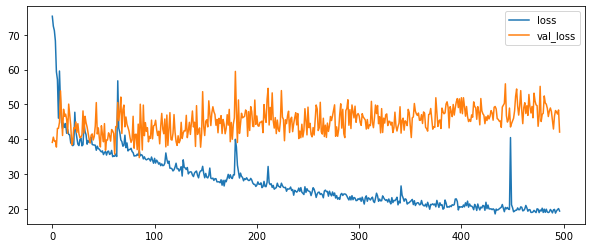

In [106]:
plot_history(history)

In [107]:
"min_loss: %.4f, min_val_loss: %.4f" % (min(history.history['loss']), min(history.history['val_loss']))

'min_loss: 18.5369, min_val_loss: 34.6930'

### Comparing with Previous Methods

| Model | Train Error | Test Error | All Set Error |
| - | - | - | - |
| Base | - | - | 78.8 |
| Random Forest | 23.9 | 47.0 | - |
| LGBM | - | 48.7 | - |
| TF Custom RNN | - | - | 70.7 |
| Keras, PP + Dense (with one dropout layer) | 21.7 | 37.8 | - |
| Keras, PP + Dense (with two dropout layers) | 25.3 | 36.9 | - |
| Keras, PP + Dense [1] | 18.9 | 35.5 | - |
| Keras, PP + Dense [2] | 18.5 | 34.7 | - |

* [1]: dropout, layer-norm, dense (128, relu), dropout, layer-norm, dense (32, relu), dense (16, relu), dense (16, **selu**), dense (1)
* [2]: dropout, layer-norm, dense (128, relu), dropout, layer-norm, dense (32, relu), dropout, layer-norm, dense (16, **selu**), dense (16, **selu**), dense (1)

In [108]:
from forecasting import get_error_with_freq
from plotting import draw_error_over_time

In [109]:
def draw_model_error(model, X, y_actual, error_freq='w', split_from=None):

    y_pred = pd.Series(model.predict(X).reshape(-1), index=y_actual.index)
    weekly_errors = get_error_with_freq(y_actual, y_pred, error_freq)
    draw_error_over_time(y_actual, y_pred, weekly_errors, split_from)

In [110]:
draw_model_error(nn_model, get_input_sets(feature_set[feature_set.columns[2:]]), feature_set[TARGET])